# Proyecto de Machine Learning Parte 2 - Selección de modelo, ajuste de hiperparámetros y evaluación

Existen [muchos modelos de machine learning](http://scikit-learn.org/stable/supervised_learning.html) para elegir y decidir por dónde empezar puede ser intimidante. Si bien hay [algunos gráficos](https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-cheat-sheet) que intentan mostrar qué algoritmo usar, preferimos probar varios y ver cuál funciona mejor. Machine learning sigue siendo un campo impulsado principalmente por [resultados empíricos (experimentales) en lugar de teóricos](https://www.quora.com/How-much-of-deep-learning-research-is-empirical-versus-theoretical), y es casi imposible saber de antemano qué modelo será el mejor.

En general, es una buena idea comenzar con modelos simples e interpretables, como la regresión lineal, y si el rendimiento no es adecuado continuar con métodos más complejos, pero generalmente más precisos. La siguiente tabla muestra una versión (altamente no científica) de precisión frente a interpretabilidad:

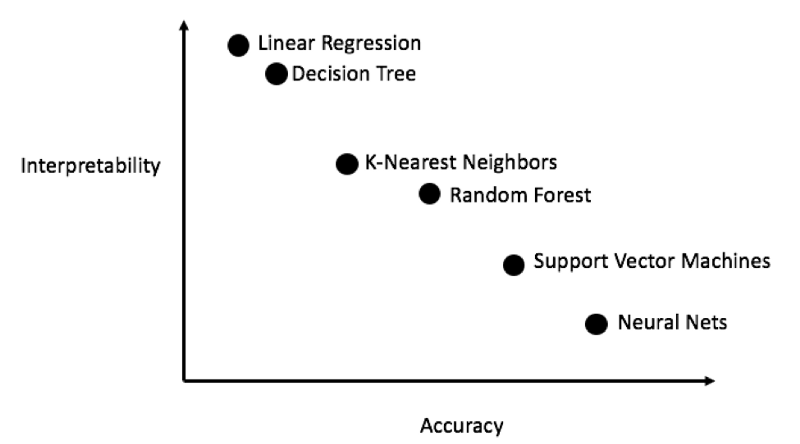

In [1]:
from IPython.display import Image
Image(filename="./images/InterpretabilidadVsAccuracy.png")

## Imports

In [2]:
# Pandas y numpy para manipulación de datos
import pandas as pd
import numpy as np

# Quitamos los warnings sobre el establecimiento de un valor en una copia de un slice
pd.options.mode.chained_assignment = None

# Mostramos hasta 60 columnas de un dataframe
pd.set_option('display.max_columns', 60)

# Visualización Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Establece el tamaño de fuente por defecto
plt.rcParams['font.size'] = 24

# Herramienta interna ipython para establecer el tamaño de la figura
from IPython.core.pylabtools import figsize

# Visualizción por Seaborn
import seaborn as sns
sns.set(font_scale = 2)

# Imputación de valores faltantes y escalado de valores
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Ajuste de Hiperparámetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Importación de datos

En primer lugar leemos los datos formateados del notebook anterior

In [3]:
# Importamos los datos en dataframes
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Mostramos el tamaños de los datos
print('Tamaño de las características de Entrenamiento: ', train_features.shape)
print('Tamaño de las características de Prueba:        ', test_features.shape)
print('Tamaño de las Etiquetas de Entrenamiento:       ', train_labels.shape)
print('Tamaño de las Etiquetas de Prueba:              ', test_labels.shape)

Tamaño de las características de Entrenamiento:  (6622, 64)
Tamaño de las características de Prueba:         (2839, 64)
Tamaño de las Etiquetas de Entrenamiento:        (6622, 1)
Tamaño de las Etiquetas de Prueba:               (2839, 1)


Como recordatorio, así es cómo se ven los datos formateados. En el primer notebook, diseñamos una serie de características tomando a partir del logaritmo de las variables, incluimos dos variables categóricas y seleccionamos un subconjunto de características mediante la eliminación de características altamente colineales.

In [4]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

La columna `score` contiene la puntuación Energy Star, el objetivo de nuestro problema de machine learning. Se supone que Energy Star Score es una medida comparativa de la eficiencia energética de un edificio, ¡aunque vimos que puede haber problemas con la forma en que se calcula esto en la primera parte!

Aquí está la distribución de Energy Star Score.

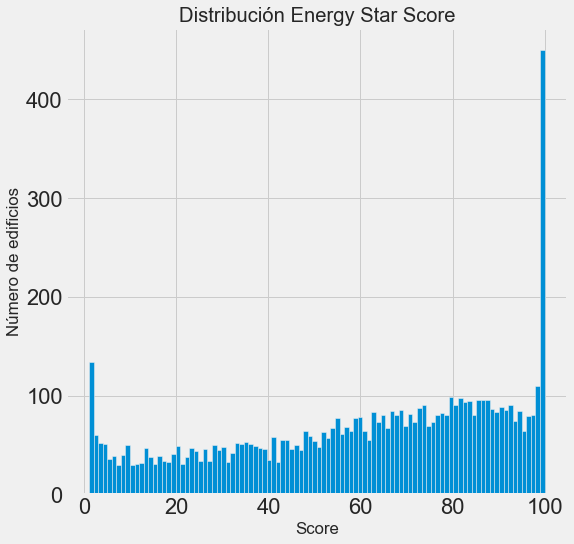

In [5]:
figsize(8, 8)

# Histograma de Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Número de edificios'); 
plt.title('Distribución Energy Star Score');

# Evaluación y comparación de modelos de Machine Learning

En esta sección construiremos, entrenaremos y evaluaremos varios métodos de machine learning para nuestra tarea de regresión supervisada. El objetivo es determinar qué modelo es el más prometedor para un mejor desempeño (como el ajuste de hiperparámetros).

Estamos comparando modelos usando el error medio absoluto. Un modelo de línea base que conjetura que el valor medio de la puntuación está fuera de un promedio de 25 puntos.

## Imputación de valores faltantes

Los modelos estándares de machine learning no pueden lidiar con los valores faltantes y eso significa que debemos encontrar una manera de completarlos o descartar cualquier característica con valores faltantes. Como ya eliminamos las características con más de un 50% de valores faltantes en la primera parte, aquí nos centraremos en completar estos valores faltantes, un proceso conocido como [imputación](https://en.wikipedia.org/wiki/Imputation_%28statistics%29). Existen varios métodos para la imputación, pero aquí usaremos el método relativamente simple de reemplazar los valores faltantes con la mediana de la columna. [(Aquí hay una discusión más completa sobre la imputación de valores perdidos)](http://www.stat.columbia.edu/~gelman/arm/missing.pdf).

En el código siguiente, creamos un [objeto Scikit-learn `SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) para completar los valores faltantes con la mediana de la columna. Observa que entrenamos al imputador (usando el método `SimpleImputer.fit`) en los datos de entrenamiento pero no en los datos de prueba. Luego, transformamos (utilizando `SimpleImputer.transform`) tanto los datos de entrenamiento como los datos de prueba. Esto significa que los valores faltantes en el conjunto de pruebas se completan con el valor de la mediana de las columnas correspondientes en el conjunto de entrenamiento. [Tenemos que hacerlo de esta manera](https://stackoverflow.com/questions/46691596/why-does-sklearn-imputer-need-to-fit/46692001#46692001) en lugar de hacerlo en tiempo de desarrollo porque tendremos que imputar los valores faltantes en nuevas observaciones basadas en los datos de entrenamiento anteriores. Esta es una forma de evitar el problema conocido como la [fuga de datos (Data leakage)](https://www.kaggle.com/dansbecker/data-leakage) donde la información del conjunto de pruebas "se fuga" en el proceso de entrenamiento.

In [6]:
# Creamos un objeto imputer con una estrategia de rellenar con la mediana
imputer = SimpleImputer(strategy='median')

# Entrenamos con las características de entrenamiento
imputer.fit(train_features)

# Transformamos tanto los datos de entrenamiento como los de prueba
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [7]:
print('Valores faltantes en características de entrenamiento: ', np.sum(np.isnan(X)))
print('Valores faltantes en características de prueba:        ', np.sum(np.isnan(X_test)))

Valores faltantes en características de entrenamiento:  0
Valores faltantes en características de prueba:         0


In [8]:
# Nos aseguramos que todos los valores son finitos
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Después de la imputación, todas las características tienen un valor real. Para métodos de imputación más sofisticados (aunque los valores de la mediana generalmente funcionan bien) consulta este [artículo](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146).

## Escalado de características (Feature Scaling)

El último paso a realizar antes de que podamos construir nuestros modelos es [escalar las características](https://en.wikipedia.org/wiki/Feature_scaling). Esto es necesario porque las características están en diferentes unidades y queremos normalizar las características para que las unidades no afecten al algoritmo. [La regresión lineal y el bosque aleatorio no requieren un escalado de características](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data), pero otros métodos, como las máquinas de vectores de soporte (support vector machines - SVM) y los k vecinos más cercanos (k nearest neighbors), lo requieren porque tienen en cuenta la distancia euclidiana entre las observaciones. Por esta razón, es una práctica recomendada escalar características cuando estamos comparando múltiples algoritmos.

Hay dos formas de [escalar características](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html):

1. Para cada valor, resta la media de la característica y divídela entre la desviación estándar de la misma. Esto se conoce como estandarización y los resultados en cada característica tienen una media de 0 y una desviación estándar de 1.
2. Para cada valor, resta el valor mínimo de la característica y divide por el máximo menos el mínimo de la característica (el rango). Esto asegura que todos los valores para una característica están entre 0 y 1 y se llama escalado a un rango o normalización.

Aquí hay un buen artículo sobre [normalización y estandarización](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

Si bien este proceso sería fácil de implementar a mano, podemos hacerlo utilizando un objeto `MinMaxScaler` de Scikit-Learn. El código para este método es idéntico al de la imputación, excepto con un escalador en lugar de un imputador. Al igual que con la imputación, cuando entrenamos el escalado del objeto, queremos usar solo el conjunto de entrenamiento. Cuando transformemos las características, transformaremos tanto el conjunto de entrenamiento como el conjunto de pruebas.

In [9]:
# Crea el objeto scaler con un rango de 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Entrenamos los datos de entrenamiento
scaler.fit(X)

# Transformamos tanto los datos de entrenamiento como los de prueba
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [10]:
# Convertimos y a un array unidimensional (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

Cada característica ahora tiene un valor mínimo de 0 y un valor máximo de 1. La imputación de valores faltantes y el escalado de características son dos pasos requeridos en casi cualquier flujo de machine learning, por lo que es una buena idea entender cómo funcionan.

## Modelos a evaluar

Compararemos cinco modelos diferentes de aprendizaje automático utilizando la gran [librería Scikit-Learn](https://scikit-learn.org/stable/):

1. Regresión lineal
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Nuevamente, aquí me estoy enfocando en la implementación en lugar de explicar cómo funcionan estos. Además de Hands-On Machine Learning, otro gran recurso (este es gratuito en línea) para leer sobre los modelos de machine learning es [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).

Para comparar los modelos, vamos a utilizar principalmente los valores predeterminados de Scikit-Learn para los modelos de hiperparámetros. En general, estos funcionarán decentemente, pero deberían optimizarse antes de usar un modelo. Al principio solo queremos determinar el rendimiento baseline de cada modelo y luego podemos seleccionar el modelo con el mejor rendimiento para una mayor optimización mediante el ajuste del hiperparámetro. Recuerda que los hiperparámetros predeterminados pondrán en funcionamiento un modelo, ¡pero casi siempre se deben ajustar utilizando algún tipo de búsqueda para encontrar la mejor configuración para tu problema!

Esto es lo que dice la documentación de Scikit-learn [sobre los valores predeterminados](https://arxiv.org/abs/1309.0238):

    Valores predeterminados sensibles: siempre que una operación requiera un parámetro definido por el usuario, 
    la librería define un valor predeterminado apropiado. El valor por defecto debe hacer que la operación se
    realice de una manera sensible (dando una solución de baseline para la tarea en cuestión).
    
Una de las mejores partes de scikit-learn es que todos los modelos se implementan de manera idéntica: una vez sepas cómo construir uno, puedes implementar una gama de modelos extremadamente diversa. Aquí implementaremos todos los procedimientos de entrenamiento y prueba para varios modelos en solo unas pocas líneas de código.

In [11]:
# Función para calcular el error medio absoluto
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Toma un modelo, lo entrena y lo evalúa en el conjunto de prueba
def fit_and_evaluate(model):
    
    # Entrena el modelo
    model.fit(X, y)
    
    # Hace predicciones y evaluación
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Devuelve la métrica de ejecución
    return model_mae

In [12]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [13]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [14]:
random_forest = RandomForestRegressor(n_estimators=10, random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 10.0073


In [15]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0144


In [16]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


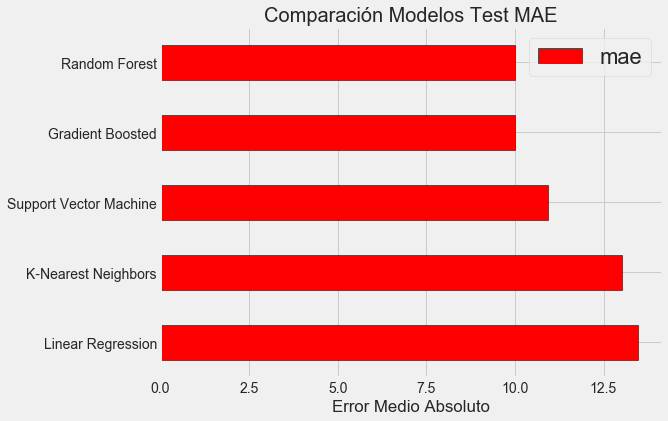

In [17]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe para almacenar los resultados
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Error Medio Absoluto'); plt.xticks(size = 14)
plt.title('Comparación Modelos Test MAE', size = 20);

Dependiendo de la ejecución (los resultados exactos cambian un poco cada vez), [Gradient Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) tiene el mejor rendimiento seguido de Random Forest. Debo admitir que esta no es la comparación más justa porque estamos utilizando principalmente los hiperparámetros predeterminados. [Especialmente con Support Vector Regressor](http://pyml.sourceforge.net/doc/howto.pdf), los hiperparámetros tienen una influencia significativa en el rendimiento. Random Forest y Gradient Boosting son excelentes para comenzar porque el rendimiento depende menos de la configuración del modelo. Para poner estas cifras en perspectiva, la línea base simple calculada utilizando el valor mediano del objetivo fue de 24.5. ¡Claramente, machine learning es aplicable a nuestro problema debido a la mejora significativa sobre la línea base!

A partir de aquí nos concentraremos en optimizar el mejor modelo utilizando el ajuste de hiperparámetros. Dados los resultados aquí nos centraremos en el uso del `GradientBoostingRegressor`. Esta es la implementación de Scikit-Learn de [Gradient Boosted Trees](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf) que ha ganado muchas [competiciones de Kaggle](http://www.matthewemery.ca/post/xgboost/) en los últimos años. La versión Scikit-Learn generalmente es más lenta que la versión `XGBoost`, pero aquí nos limitaremos a Scikit-Learn porque la sintaxis es más familiar. [Aquí hay una guía](https://www.kaggle.com/dansbecker/xgboost/code) para usar la implementación en el paquete XGBoost.

Ya que usaremos el modelo de Gradient Boosting Regressor, un poco de background. Este modelo es un método de conjunto, lo que significa que está construido a partir de muchos aprendices débiles, en este caso, árboles de decisión individuales. Mientras que un [algoritmo *bagging* como el bosque aleatorio](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) entrena a los aprendices débiles en paralelo y los hace votar para hacer una predicción, un [método *boosting*](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) como Gradient Boosting, entrena a los aprendices en secuencia, donde cada aprendiz se "concentra" en los errores cometidos por los anteriores.

Los métodos boosting se han vuelto populares en los últimos años y con frecuencia ganan competencias de machine learning. El método [Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) es una implementación particular que utiliza Gradient Descent para minimizar la función de costo al capacitar a los aprendices en forma secuencial sobre los residuos de los anteriores. La implementación de Scikit-Learn de Gradient Boosting generalmente se considera menos eficiente que otras bibliotecas como [XGBoost](https://xgboost.readthedocs.io/en/latest/), pero funcionará lo suficientemente bien para nuestro pequeño conjunto de datos y es bastante precisa.

## Optimización del modelo

En machine learning, optimizar un modelo significa encontrar el mejor conjunto de hiperparámetros para un problema en particular.

### Hiperparámetros

En primer lugar, debemos entender qué son los [hiperparámetros del modelo en contraste con los parámetros del modelo](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/):

+ Los **hiperparámetros** de modelo se consideran como ajustes para un algoritmo de machine learning que el científico de datos ajusta antes del entrenamiento. Algunos ejemplos serían la cantidad de árboles en el bosque aleatorio o la cantidad de vecinos utilizados en K Nearest Neighbors.
+ Los **parámetros** del modelo son lo que el modelo aprende durante el entrenamiento, como los pesos en la regresión lineal.

Nosotros, como científicos de datos, controlamos un modelo seleccionando los hiperparámetros y estas opciones pueden tener un efecto significativo en el rendimiento final del modelo (aunque generalmente no es un efecto tan importante como obtener más datos o ingeniería de características).

El [ajuste de los hiperparámetros del modelo](https://scikit-learn.org/stable/modules/grid_search.html) controla el equilibrio entre ajuste insuficiente y sobre ajuste en un modelo ([*under vs overfitting*](https://towardsdatascience.com/overfitting-vs-underfitting-a-conceptual-explanation-d94ee20ca7f9)). Podemos intentar corregir el *underfitting* haciendo un modelo más complejo, como usar más árboles en un bosque aleatorio o más capas en una red neuronal profunda. Un modelo con underfitting tiene un [alto sesgo](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) y ocurre cuando nuestro modelo no tiene la capacidad suficiente (grados de libertad) para aprender la relación entre las características y el objetivo. Podemos tratar de corregir el *overfitting* limitando la complejidad del modelo y aplicando regularización. Esto podría significar disminuir el grado de una regresión polinomial o agregar capas dropout a una red neuronal profunda. Un modelo con overfitting tiene una gran varianza y en efecto ha memorizado el conjunto de entrenamiento. Tanto el underfitting como el overfitting llevan a una deficiente generalización en el conjunto de pruebas.

El problema con la elección de los hiperparámetros es que ningún conjunto funcionará mejor en todos los problemas. Por lo tanto, para cada nuevo conjunto de datos tenemos que encontrar la mejor configuración. Este proceso puede llevar mucho tiempo, pero afortunadamente hay varias opciones para realizar este procedimiento en Scikit-Learn. Aún mejor, las nuevas librerías, como [TPOT](https://epistasislab.github.io/tpot/) de epistasis labs, tienen como objetivo realizar este proceso automáticamente por ti. Por ahora, nos limitaremos a hacer esto manualmente (en cierto modo) en Scikit-Learn.

### Ajuste de hiperparámetros con Búsqueda Aleatoria y Validación Cruzada

Podemos elegir los mejores hiperparámetros para un modelo a través de búsqueda aleatoria (random search) y validación cruzada (cross validation).

+ La **búsqueda aleatoria** se refiere al método en el que elegimos los hiperparámetros para evaluar: definimos un rango de opciones y luego seleccionamos combinaciones aleatoriamente para probar. Esto contrasta con la búsqueda de cuadrícula (grid search) que evalúa cada combinación individual que especificamos. En general, la búsqueda aleatoria es mejor cuando tenemos un conocimiento limitado del mejor modelo de hiperparámetros y podemos usar la búsqueda aleatoria para reducir las opciones y luego usar la búsqueda de cuadrícula con un rango más limitado de opciones.
+ La **validación cruzada** es el método utilizado para evaluar el rendimiento de los hiperparámetros. En lugar de dividir el conjunto de entrenamiento en conjuntos de entrenamiento y validación separados, lo que reduce la cantidad de datos de entrenamiento que podemos utilizar, usamos la validación cruzada K-Fold (K-Fold Cross Validation). Esto significa dividir los datos de entrenamiento en K folds, y luego pasar por un proceso iterativo en el que primero entrenamos en K-1 de los folds y luego evaluamos el desempeño en el K fold. Repetimos este proceso K veces, por lo que eventualmente habremos probado todos los ejemplos de los datos de entrenamiento con la clave de que cada iteración la estamos probando con datos en los que **no entrenamos**. Al final de la validación cruzada de K-fold, tomamos el error promedio en cada una de las K iteraciones como la medida de rendimiento final y luego entrenamos el modelo en todos los datos de entrenamiento a la vez. El rendimiento que registramos se utiliza para comparar diferentes combinaciones de hiperparámetros.

A continuación se muestra una imagen de la validación cruzada k-fold utilizando k = 5:

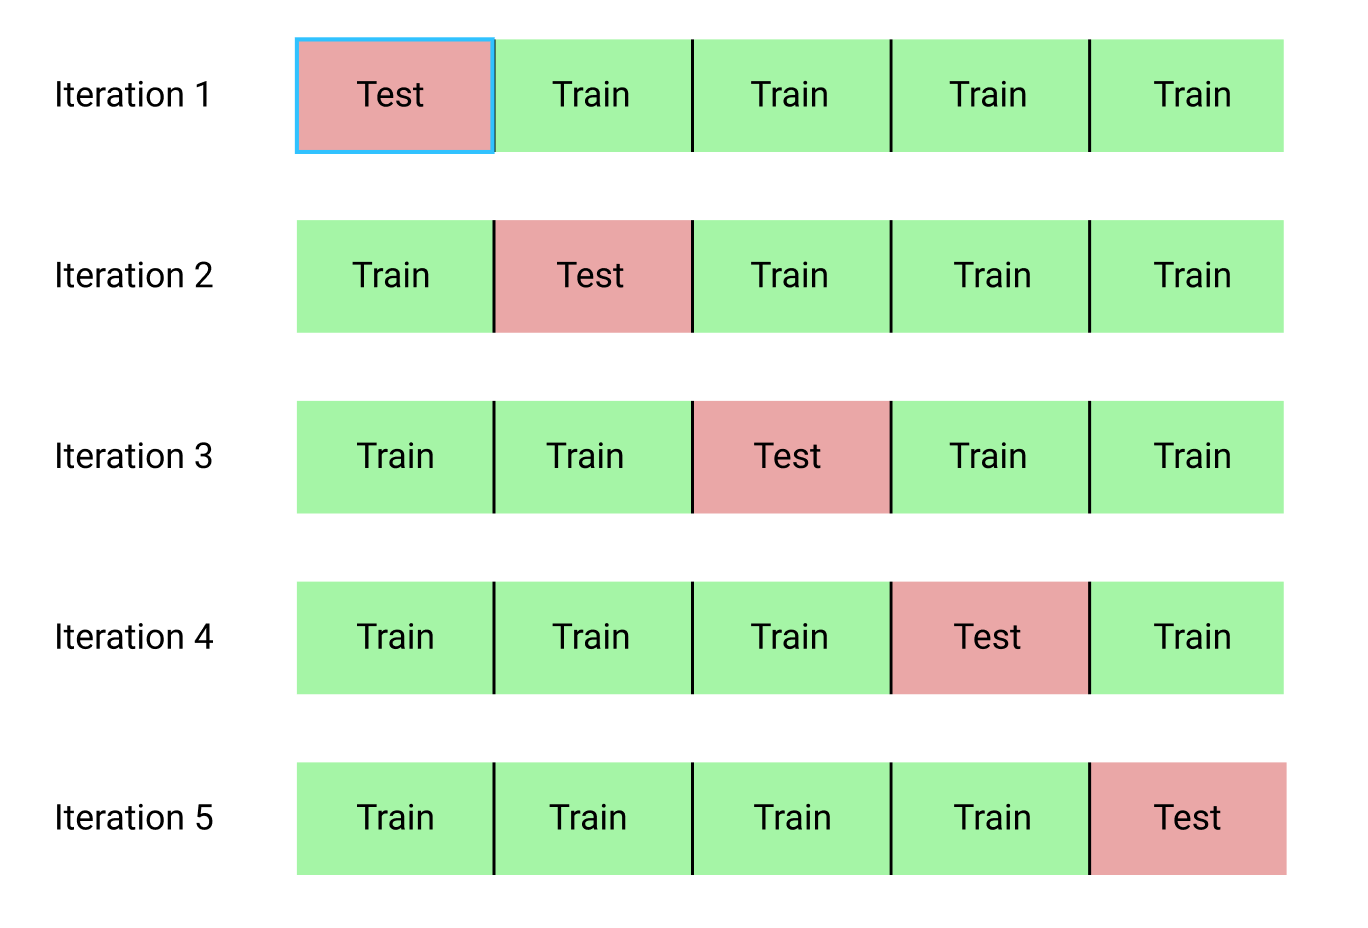

In [18]:
Image(filename="./images/kfold_cv.png")

Aquí implementaremos una búsqueda aleatoria con validación cruzada para seleccionar los hiperparámetros óptimos para Gradient Boosting Regressor. Primero definimos una cuadrícula, luego realizamos un proceso iterativo de: 

+ muestreamos aleatoriamente un conjunto de hiperparámetros de la cuadrícula
+ evaluamos los hiperparámetros usando una validación cruzada 4-fold
+ seleccionamos los hiperparámetros con el mejor rendimiento.

Por supuesto que nosotros mismos no hacemos esta iteración, dejamos que Scikit-Learn y `RandomizedSearchCV` hagan el proceso por nosotros.

In [19]:
# Función de pérdida a ser optimizada
loss = ['ls', 'lad', 'huber']

# Número de árboles usados en el proceso de boosting
n_estimators = [100, 500, 900, 1100, 1500]

# Máxima profundidad de cada árbol
max_depth = [2, 3, 5, 10, 15]

# Mínimo número de muestras por hoja
min_samples_leaf = [1, 2, 4, 6, 8]

# Mínimo número de muestras para dividir un nodo
min_samples_split = [2, 4, 6, 10]

# Máximo número de características a considerar para hacer una división
max_features = ['auto', 'sqrt', 'log2', None]

# Definimos la rejilla de hiperparámetros a buscar
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

Seleccionamos 6 hiperparámetros diferentes para ajustar en Gradient Boosting Regressor. Todo esto afectará al modelo de diferentes maneras que son difíciles de determinar con anticipación y el único método para encontrar la mejor combinación para un problema específico es probarlos. Para leer sobre los hiperparámetros, sugiero echar un vistazo a la [documentación de Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor). Por ahora, solo saber que estamos tratando de encontrar la mejor combinación de hiperparámetros y debido a que no hay ninguna teoría que nos diga cuál funcionará mejor, ¡solo tenemos que evaluarlos, como ejecutar un experimento!

En el siguiente código, creamos el objeto `Randomized Search` que pasa en los siguientes parámetros:

+ `estimator`: el modelo
+ `param_distributions`: la distribución de parámetros que hemos definido
+ `cv`: el número de folds a utilizar para la validación cruzada k-fold
+ `n_iter`: el número de combinaciones diferentes a probar
+ `scoring`: qué métrica utilizar al evaluar candidatos
+ `n_jobs`: número de cores que se ejecutarán en paralelo (-1 utilizará todos los disponibles)
+ `verbose`: cuánta información mostrar (1 muestra una cantidad limitada)
+ `return_train_score`: devuelve la puntuación de entrenamiento para cada fold de validación cruzada
+ `random_state`: establece el generador de números aleatorios utilizado para que obtengamos los mismos resultados en cada ejecución

El objeto Randomized Search se entrena de la misma manera que cualquier otro modelo de scikit-learn. Después del entrenamiento, podemos comparar las diferentes combinaciones de hiperparámetros y encontrar la mejor.

In [20]:
# Crea el modelo a usar para el ajuste de hiperparámetros
model = GradientBoostingRegressor(random_state = 42)

# Establece la búsqueda aleatoria con validación cruzada 4-fold
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [21]:
# Entrena los datos de entrenamiento
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Scikit-learn utiliza el error medio absoluto negativo para la evaluación porque desea que una métrica maximice. Por lo tanto, una mejor puntuación estará más cerca de 0. Podemos obtener los resultados de la búsqueda aleatoria en un dataframe y clasificar los valores por rendimiento.

In [22]:
# Obtiene todos los resultado de cv y los ordena por rendimiento
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,10.196753,0.303679,0.020000,0.001000,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.859660,-8.775078,-9.325044,-9.037550,-8.999278,0.210556,1,-7.027368,-6.837958,-6.869084,-6.840749,-6.893790,0.078077
3,11.832501,1.211618,0.023001,0.002909,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.870442,-8.903982,-9.317120,-9.075047,-9.041601,0.176957,2,-4.482073,-4.326121,-4.823009,-4.229809,-4.465253,0.225313
9,6.602499,0.271197,0.013999,0.001221,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.133949,-9.042221,-9.439618,-9.153004,-9.192167,0.148852,3,-7.007604,-7.088986,-6.913108,-6.940327,-6.987506,0.067939
0,1.932507,0.084668,0.005751,0.000827,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.100775,-9.026372,-9.457063,-9.201235,-9.196321,0.162799,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,6.289999,0.643810,0.014497,0.002598,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.147703,-9.199053,-9.698781,-9.358627,-9.350987,0.215296,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,61.305001,3.035453,0.107752,0.020582,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.257896,-9.242743,-9.530568,-9.475944,-9.376750,0.128046,6,-0.378166,-0.459465,-0.393491,-0.370483,-0.400401,0.035092
19,13.668996,1.471912,0.026753,0.001920,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.379266,-9.382812,-9.475236,-9.291753,-9.382266,0.064885,7,-8.311796,-8.658903,-7.820534,-8.017995,-8.202307,0.316303
2,39.278252,1.237573,0.048250,0.002045,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.392251,-9.291198,-9.575363,-9.429866,-9.422145,0.101949,8,-0.164859,-0.193613,-0.164415,-0.141062,-0.165987,0.018629
16,19.863251,0.146443,0.043247,0.003110,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.248892,-9.316306,-9.798843,-9.427920,-9.447940,0.212403,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,4.974753,0.605181,0.023996,0.000713,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.394785,-9.286988,-9.751767,-9.409179,-9.460643,0.174556,10,-5.684121,-5.742441,-5.571781,-5.666476,-5.666205,0.061337


In [23]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

El mejor modelo de Gradient Boosted tiene los siguientes hiperparámetros:

+ `lost` = lad
+ `n_estimators` = 500
+ `max_depth` = 5
+ `min_samples_leaf` = 6
+ `min_samples_split` = 6
+ `max_features` = None (Esto significa que `max_features = n_features` de acuerdo con los documentos)

El uso de la búsqueda aleatoria es un buen método para reducir los posibles hiperparámetros a intentar. Inicialmente, no teníamos idea de qué combinación funcionaría mejor, pero esto al menos reduce el rango de opciones.

Podríamos utilizar los resultados de la búsqueda aleatoria para informar una búsqueda de cuadrícula creando una cuadrícula con hiperparámetros cercanos a los que funcionaron mejor durante la búsqueda aleatoria. Sin embargo, en lugar de evaluar nuevamente todas estas configuraciones, nos centraremos en una sola, la cantidad de árboles en el bosque (`n_estimators`). Al variar solo un hiperparámetro podemos observar directamente cómo afecta al rendimiento. En el caso del número de árboles, esperaríamos ver un efecto significativo en la cantidad de under vs overfitting.

Aquí usaremos la búsqueda de cuadrícula con una cuadrícula que solo tiene el hiperparámetro `n_estimators`. Evaluaremos un rango de árboles y luego dibujaremos el rendimiento del entrenamiento y las pruebas para tener una idea de lo que supone aumentar el número de árboles para nuestro modelo. Estableceremos los otros hiperparámetros en los mejores valores devueltos de la búsqueda aleatoria para aislar el efecto del número de árboles.

In [24]:
# Creamos un rango de árboles a evaluar
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Objeto GridSearch usando el rango de árboles y el modelo random forest
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [25]:
# Entrenamos el grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.9s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samp...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

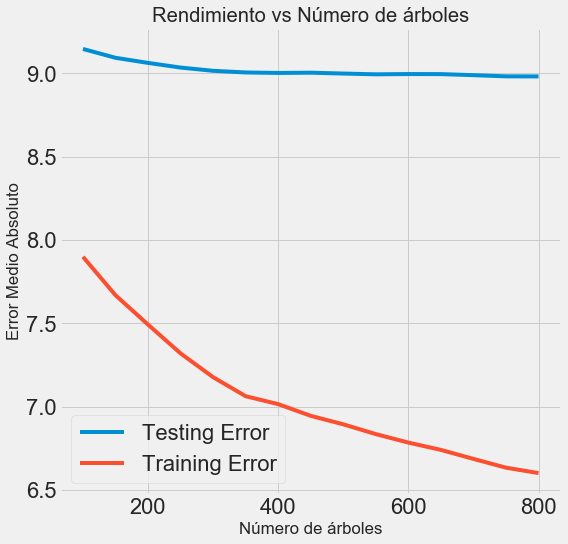

In [26]:
# Obtenemos los resultados en un dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Dibujamos el error de entrenamiento y prueba vs número de árboles
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Número de árboles'); plt.ylabel('Error Medio Absoluto'); plt.legend();
plt.title('Rendimiento vs Número de árboles');

In [27]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,12.998742,0.882712,0.018252,0.001089,800,{'n_estimators': 800},-8.825290,-8.758299,-9.296941,-9.047485,-8.981946,0.210990,1,-6.739448,-6.648109,-6.486269,-6.530287,-6.601028,0.099437
13,15.990995,0.686765,0.018496,0.000499,750,{'n_estimators': 750},-8.830566,-8.751699,-9.298411,-9.049730,-8.982544,0.212523,2,-6.772908,-6.660453,-6.520818,-6.579989,-6.633542,0.094501
12,17.746240,0.316541,0.023247,0.004816,700,{'n_estimators': 700},-8.836049,-8.755862,-9.312990,-9.053755,-8.989605,0.216159,3,-6.812928,-6.695770,-6.611240,-6.624919,-6.686214,0.079884
9,15.160751,0.172018,0.025244,0.001479,550,{'n_estimators': 550},-8.853730,-8.756938,-9.325492,-9.042721,-8.994663,0.216865,4,-7.003413,-6.781878,-6.809121,-6.745712,-6.835031,0.099783
11,17.788758,0.364420,0.027994,0.001216,650,{'n_estimators': 650},-8.851136,-8.755401,-9.325190,-9.052215,-8.995928,0.218168,5,-6.864375,-6.721452,-6.708191,-6.666758,-6.740194,0.074480


A partir de este gráfico, ¡queda bastante claro que nuestro modelo tiene [overfitting](https://elitedatascience.com/overfitting-in-machine-learning)! El error de entrenamiento es significativamente más bajo que el error de prueba, lo que muestra que el modelo está aprendiendo muy bien los datos de entrenamiento, pero no es capaz de generalizar los datos de prueba tan bien. Además, a medida que aumenta el número de árboles, aumenta la cantidad de overfitting. Tanto el error de prueba como el de entrenamiento disminuyen a medida que aumenta la cantidad de árboles, pero el error de entrenamiento disminuye más rápidamente.

Siempre habrá una diferencia entre el error de entrenamiento y el error de prueba (el error de entrenamiento siempre es menor) pero si hay una diferencia significativa queremos intentar reducir el overfitting, ya sea obteniendo más datos de entrenamiento o reduciendo la complejidad del modelo, a través del ajuste del hiperparámetro o regularización. Para [Gradient Boosted Regressor](https://www.quora.com/How-do-you-correct-for-overfitting-for-a-Gradient-Boosted-Machine), algunas opciones incluyen reducir el número de árboles, reducir la profundidad máxima de cada árbol y aumentar el mínimo de muestras en un nodo de hoja. Para cualquier persona que quiera ir más allá en Gradient Boosted Regressor [aquí hay un gran artículo](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/). Por ahora, usaremos el modelo con el mejor rendimiento y aceptaremos que puede tener overfitting para el conjunto de entrenamiento.

Basado en los resultados de la validación cruzada, el mejor modelo con 800 árboles logra un error de validación cruzada por debajo de 9. ¡Esto indica que la estimación de validación cruzada promedio de la puntuación Energy Star está dentro de los 9 puntos de la respuesta verdadera!

## Evaluar el modelo final en el conjunto de prueba

Usaremos el mejor modelo de ajuste de hiperparámetros para hacer predicciones sobre el conjunto de pruebas. Recuerda, nuestro modelo nunca antes había visto el conjunto de pruebas, por lo que este rendimiento debería ser un buen indicador de cómo se desempeñaría el modelo si se implementara en el mundo real.

A modo de comparación, también podemos observar el rendimiento del modelo predeterminado. El código siguiente crea el modelo final, lo entrena (con tiempo) y evalúa en el conjunto de prueba.

In [28]:
# Modelo por defecto
default_model = GradientBoostingRegressor(random_state = 42)

# Selecciona el mejor modelo
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

676 ms ± 5.49 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [30]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

9.83 s ± 18.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [31]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Rendimiento del modelo por defecto en el conjunto de prueba: MAE = %0.4f.' % mae(y_test, default_pred))
print('Rendimiento del modelo final en el conjunto de prueba:       MAE = %0.4f.' % mae(y_test, final_pred))

Rendimiento del modelo por defecto en el conjunto de prueba: MAE = 10.0130.
Rendimiento del modelo final en el conjunto de prueba:       MAE = 9.0453.


El modelo final supera al modelo de baseline en aproximadamente un 10%, pero a costa de un tiempo de ejecución significativamente mayor (es aproximadamente 14 veces más lento en mi máquina). Machine learning es a menudo un campo de intercambio: sesgo frente a varianza, precisión frente a interpretabilidad, precisión frente a tiempo de ejecución, y la decisión final de qué modelo usar depende de la situación. Aquí el aumento en el tiempo de ejecución no es un impedimento, porque mientras que la diferencia relativa es grande, la magnitud absoluta del tiempo de entrenamiento no es significativa. En una situación diferente, el balance podría no ser el mismo, por lo que deberíamos considerar para qué estamos optimizando y las limitaciones con las que tenemos que trabajar.

Para tener una idea de las predicciones, podemos dibujar la distribución de los valores verdaderos en el conjunto de prueba y los valores predichos en el conjunto de prueba.

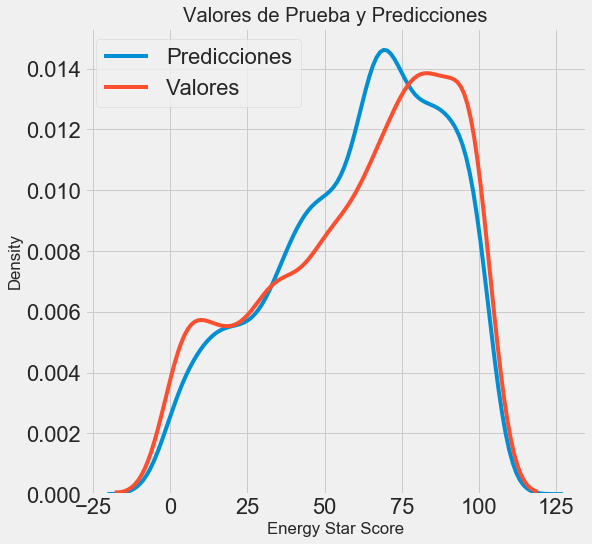

In [32]:
figsize(8, 8)

# Plot de densidad de las predicciones finales y los valores de prueba
sns.kdeplot(final_pred, label = 'Predicciones')
sns.kdeplot(y_test, label = 'Valores')

# Etiquetamos el gráfico
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Valores de Prueba y Predicciones');

La distribución parece ser casi la misma, aunque la densidad de los valores pronosticados es más cercana a la mediana (66) de los valores de prueba en lugar de al pico real en 100. Parece que el modelo puede ser menos preciso para predecir los valores extremos y, en cambio, predice los valores más cerca de la mediana.

Otra gráfica de diagnóstico es un histograma de los residuos. Idealmente, esperamos que los residuos se distribuyan normalmente, lo que significa que el modelo está equivocado en la misma cantidad en ambas direcciones (alta y baja).

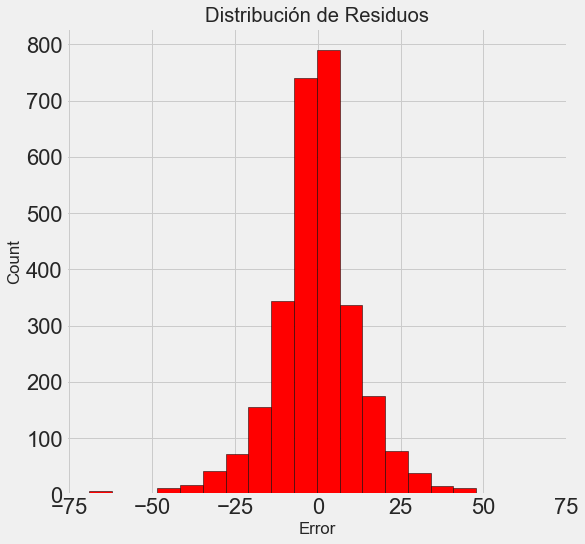

In [33]:
figsize = (6, 6)

# Calcula los residuos
residuals = final_pred - y_test

# Dibuja los residuos en un histograma
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribución de Residuos');

Los residuos están cerca de la distribución normal, con unos pocos valores atípicos notorios en el extremo inferior. Estos indican errores en los que la estimación del modelo fue muy inferior a la del valor real.

## Conclusiones

En este notebook cubrimos conceptos cruciales en el flujo de machine learning:

+ Imputar valores faltantes
+ Evaluar y comparar varios métodos de machine learning.
+ Ajustar de hiperparámetros de un modelo de machine learning mediante búsqueda aleatoria y validación cruzada
+ Evaluar el mejor modelo en el conjunto de pruebas

Los resultados nos mostraron que machine learning es aplicable a nuestro problema, con el modelo final capaz de predecir la puntuación Energy Star de un edificio dentro de 9,1 puntos. También vimos que la optimización de hiperparámetros fue capaz de mejorar el rendimiento del modelo aunque a un coste considerable en términos de tiempo invertido. Este es un buen recordatorio de que la ingeniería de características adecuada y la recopilación de más datos (¡si es posible!) tienen un beneficio mucho mayor que la optimización del modelo. También observamos el compromiso entre el tiempo de ejecución y la precisión, que es una de las muchas consideraciones que debemos tener en cuenta al diseñar modelos de machine learning.

Sabemos que nuestro modelo es preciso, pero ¿sabemos por qué hace las predicciones que hace? El siguiente paso en el proceso de machine learning es crucial: tratar de entender cómo el modelo hace predicciones. Lograr una alta precisión es excelente, pero también sería útil si pudiéramos descubrir por qué el modelo es capaz de predecir con precisión, de modo que podamos usar esta información para comprender mejor el problema. Por ejemplo, ¿en qué características se basa el modelo para inferir la puntuación Energy Star? ¿Es posible usar este modelo para la selección de características e implementar un modelo más simple que sea más interpretable?

En el siguiente notebook intentaremos responder estas preguntas y sacar conclusiones finales del proyecto.